# 1 Imports


In [ ]:
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns 

from matplotlib import pyplot as plt
pd.options.display.float_format = '{:.2f}'.format


# 2 File Reading


In [ ]:
path = '../eda_rossmann/data/train.csv'
path1 = '../eda_rossmann/data/store.csv'
df_sales_raw = pd.read_csv(path)
df_store_raw = pd.read_csv(path1)


C:\Users\Thales\AppData\Local\Temp\ipykernel_13068\230633613.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales_raw = pd.read_csv(path)


# 3 Merge of Datasets, Rename Columns





## 3.1 Merge of Datasets



In [ ]:
df = df_sales_raw.merge(df_store_raw, how='left', on='Store')

## 3.2 Rename Columns


In [ ]:
col_old_names = df.columns
snake_case = lambda x: inflection.underscore(x)
cols_new_names = list(map(snake_case,col_old_names))
df.columns = cols_new_names

# 4 Data Description


## 4.1 Rows Filtering and Cols Drop



### 4.1.1 Rows Filtering

In [ ]:
df1 = df[(df['sales'] > 0) & (df['open'] != 0)].copy()



### 4.1.2 Cols Drop

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval']
df1 = df1.drop(cols_drop, axis=1)



## 4.2 Data Dimension 


In [ ]:
print(f'The number of rows is: {df1.shape[0]}')
print(f'The number of columns is: {df1.shape[1]}')



The number of rows is: 844338
The number of columns is: 15


## 4.3 Check and Change Data Types Before NA Treatment


In [ ]:
df1.dtypes
df1['date']  = pd.to_datetime(df['date'])




### 4.3.1 Check NA


In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2186
competition_open_since_month    268600
competition_open_since_year     268600
promo2                               0
promo2_since_week               423292
promo2_since_year               423292
dtype: int64

## 4.4 NA Treatment

In [ ]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if pd.isna(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                                if pd.isna(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1 )

df1['competition_distance'] = df1.apply(lambda x: 200000 if 
                                        pd.isna(x['competition_distance'])
                                        else x['competition_distance'], axis = 1)

df1['promo2_since_week'] = df1['promo2_since_week'].fillna(0)
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(0)


## 4.5 Check Data Types

In [ ]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
dtype: object

# 4.6 Change Data Types

In [ ]:

df1['sales'] = df1['sales'].astype(float)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 5 Descriptive Stats

<Axes: xlabel='assortment', ylabel='sales'>

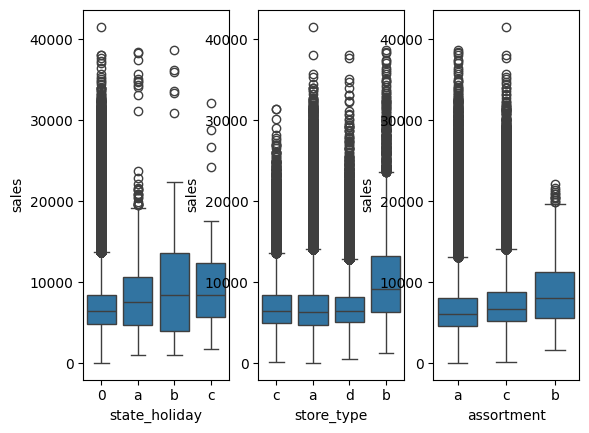

In [ ]:
df2 = df1.copy()


# Separate Categorical and Numerical Features
num_features = df2.select_dtypes(include=['int', 'float'])
cat_features = df2.select_dtypes(exclude=['int','float', 'datetime64'])

# Descriptive Stats for Numerical Features
num_features.describe().T


#Descriptive Stats for Categorical Features

# Count of Unique Elements for Each Feature
cat_features.apply(lambda x: x.unique().shape[0])

aux = df2[df2['state_holiday'] != 0]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)

# The data is too disperse. The number of outliers is pretty high.


# 6 Feature Engineering

In [ ]:
df3 = df2.copy()


# Year
df3['year'] = df3['date'].dt.year

# Month
df3['month'] = df3['date'].dt.month

# Day
df3['day'] = df3['date'].dt.day

# Weel of Year
df3['week_of_year'] = df3['date'].dt.strftime( '%Y-%W' )

# Assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' 
                                            else 'extra' if x == 'b'
                                            else 'extended')

# State Holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if 
                                                  x == 'a'
                                                  else 'easter_holiday' 
                                                  if x == 'b'
                                                  else 'christmas'
                                                  if x == 'c'
                                                  else 'regular_day')


# 7 EDA 

In [ ]:

df4 = df3.copy()



## 7.1 Hipothesis 


In [ ]:

# Stores with more assortment should sell more
# Stores with closer competitors should sell less
# Stores with old competitors should sell more
# Stores with long time promotions should sell more
# Stores with more consecutive promotion days should sell more
# Stores open on christmas should sell more
# Stores should sell more over the years
# Stores should sell more on the second semester
# Stores should sell more after day 10
# Stores should sell less on 
# Stores should sell less on student holidays



## 7.2 Univariate Analysis


### 7.2.1 Response Variable


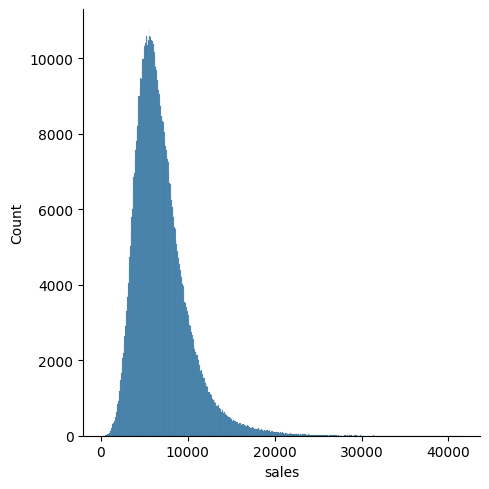

In [ ]:
sns.displot(df4['sales'])


### 7.2.2 Numerical Variables

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>],
       [<Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>],
       [<Axes: title={'center': 'promo2_since_week'}>,
        <Axes: title={'center': 'promo2_since_year'}>, <Axes: >]],
      dtype=object)

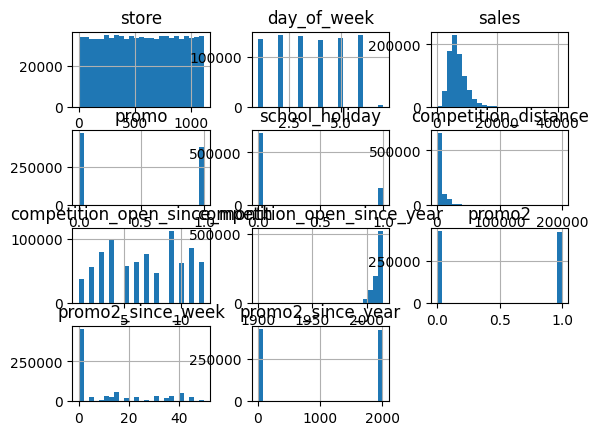

In [ ]:
num_features.hist(bins=25)

### 7.2.3 Categorical Variables

C:\Users\Thales\AppData\Local\Temp\ipykernel_13068\539770138.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'] ['sales'],
C:\Users\Thales\AppData\Local\Temp\ipykernel_13068\539770138.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'] ['sales'],
C:\Users\Thales\AppData\Local\Temp\ipykernel_13068\539770138.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas'] ['sales'],
C:\Users\Thales\AppData\Local\Temp\ipykernel_13068\539770138.py:20: FutureWarning: 

`shade` is now deprecated in favor of

<Axes: xlabel='sales', ylabel='Density'>

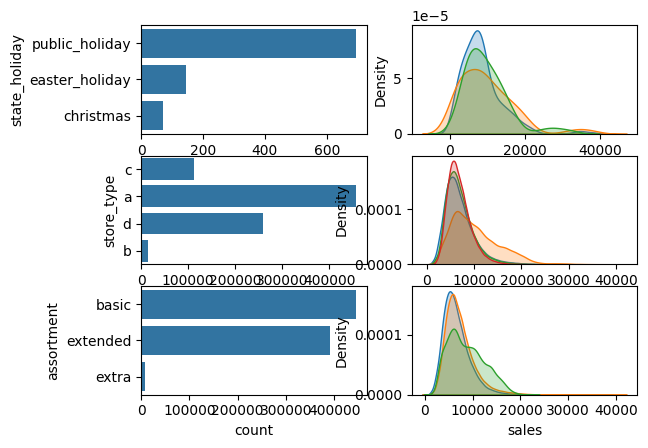

In [ ]:
# State Holiday
plt.subplot(3,2,1)
aux1 = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(aux1['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'] ['sales'], 
            label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'] ['sales'], 
            label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas'] ['sales'], 
            label = 'christmas', shade=True)


# Store Type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a'] ['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b'] ['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c'] ['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd'] ['sales'], label = 'd', shade=True)

# Assortment 
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic'] ['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended'] ['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra'] ['sales'], label = 'extra', shade=True)


## 7.3 Bivariate Analysis

### 7.3.1 Stores with more assortment should sell more

In [21]:
assortment_grouped =  df4[['sales', 'assortment']].groupby(df4['assortment']).sum().reset_index()
assortment_grouped

In [ ]:
sns.barplot(x=assortment_grouped['assortment'], y=assortment_grouped['sales'], data=assortment_grouped)